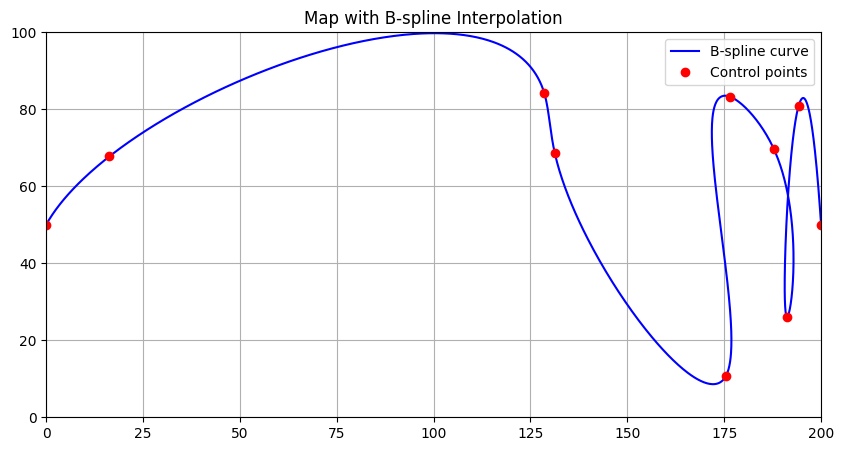

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Define map size
width, height = 200, 100

# Number of points (including the two fixed points)
num_points = 10

# Initialize array for points
points = np.zeros((num_points, 2))

# Set the first and last points to the middle positions on the left and right sides
points[0] = [0, height / 2]         # Left middle point
points[-1] = [width, height / 2]    # Right middle point

# Generate random points for the remaining positions
# Exclude first and last indices since they're fixed
for i in range(1, num_points - 1):
    x_random = np.random.uniform(0, width)
    y_random = np.random.uniform(0, height)
    points[i] = [x_random, y_random]

# Sort points based on x-coordinate to make the curve more smooth
points = points[np.argsort(points[:, 0])]

# Extract x and y coordinates
x = points[:, 0]
y = points[:, 1]

# Create a B-spline representation of the curve
tck, u = splprep([x, y], s=0)

# Evaluate the B-spline over a parameter range
unew = np.linspace(0, 1.0, num=1000)
out = splev(unew, tck)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(out[0], out[1], 'b-', label='B-spline curve')
plt.plot(x, y, 'ro', label='Control points')
plt.xlim(0, width)
plt.ylim(0, height)
plt.title('Map with B-spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()


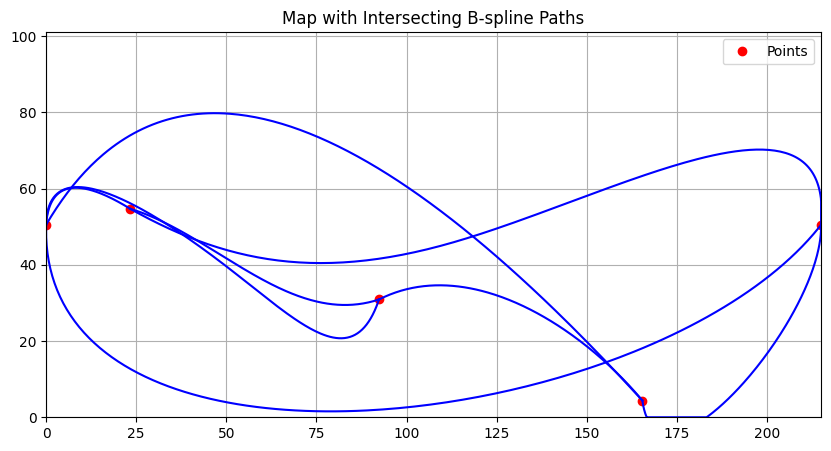

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Define map size
width, height = 215, 101

# Number of points (including the two fixed points)
num_points = 5

# Initialize array for points
points = np.zeros((num_points, 2))

# Set the first and last points to the middle positions on the left and right sides
points[0] = [0, height / 2]         # Left middle point
points[-1] = [width, height / 2]    # Right middle point

# Generate random points for the remaining positions
for i in range(1, num_points - 1):
    x_random = np.random.uniform(0, width)
    y_random = np.random.uniform(0, height)
    points[i] = [x_random, y_random]

# Plot the points
plt.figure(figsize=(10, 5))
plt.plot(points[:, 0], points[:, 1], 'ro', label='Points')

# Set a seed for reproducibility
np.random.seed(None)

# Create a list to store connections (edges)
connections = []

# For more complex channels, randomly connect points to multiple other points
for i in range(num_points):
    # Decide how many connections each point has (1 to num_points - 1)
    num_connections = np.random.randint(1, num_points)
    # Randomly choose points to connect to
    connected_points = np.random.choice(range(num_points), size=num_connections, replace=False)
    for j in connected_points:
        if i != j:
            # Avoid duplicate connections
            connection = tuple(sorted((i, j)))
            if connection not in connections:
                connections.append(connection)

# Function to ensure spline stays within the map
def clip_spline(x, y):
    x = np.clip(x, 0, width)
    y = np.clip(y, 0, height)
    return x, y

# Generate and plot splines for each connection
for conn in connections:
    idx1, idx2 = conn
    point1 = points[idx1]
    point2 = points[idx2]

    # Generate random control points between the two points
    num_ctrl_points = np.random.randint(1, 4)  # Number of control points between 2 and 4
    ctrl_x = np.linspace(point1[0], point2[0], num=num_ctrl_points)
    ctrl_y = np.linspace(point1[1], point2[1], num=num_ctrl_points)

    # Add random perturbation to control points
    perturbation = np.random.uniform(-10, 10, size=(num_ctrl_points, 2))
    ctrl_points = np.vstack((ctrl_x, ctrl_y)).T + perturbation

    # Ensure control points are within the map boundaries
    ctrl_points[:, 0] = np.clip(ctrl_points[:, 0], 0, width)
    ctrl_points[:, 1] = np.clip(ctrl_points[:, 1], 0, height)

    # Combine start point, control points, and end point
    x = np.hstack(([point1[0]], ctrl_points[:, 0], [point2[0]]))
    y = np.hstack(([point1[1]], ctrl_points[:, 1], [point2[1]]))

    # Create a B-spline representation of the curve
    tck, u = splprep([x, y], s=0, k=min(3, len(x)-1))

    # Evaluate the B-spline over a parameter range
    unew = np.linspace(0, 1.0, num=200)
    out = splev(unew, tck)

    # Clip spline to map boundaries
    out_clipped = clip_spline(out[0], out[1])

    # Plot the spline
    plt.plot(out_clipped[0], out_clipped[1], 'b-')

# Finalize the plot
plt.xlim(0, width)
plt.ylim(0, height)
plt.title('Map with Intersecting B-spline Paths')
plt.legend()
plt.grid(True)
plt.show()


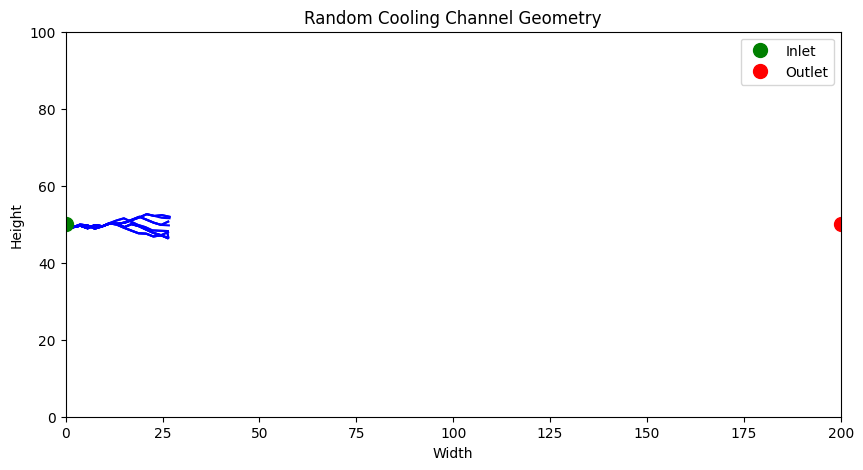

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Parameters for the random walk
step_size = 2
p_branch = 0.2   # Probability of branching
p_merge = 0.1    # Probability of merging paths
bias_strength = 0.7  # Bias towards the outlet

# Initialize active paths with the inlet
active_paths = [{'points': [inlet], 'completed': False}]
completed_paths = []

# Function to compute a biased random step towards the outlet
def biased_step(current_point):
    direction_to_outlet = outlet - current_point
    direction_to_outlet = direction_to_outlet / np.linalg.norm(direction_to_outlet)
    random_direction = np.random.randn(2)
    random_direction = random_direction / np.linalg.norm(random_direction)
    direction = bias_strength * direction_to_outlet + (1 - bias_strength) * random_direction
    direction = direction / np.linalg.norm(direction)
    step = step_size * direction
    new_point = current_point + step
    return new_point

# Main loop
while active_paths:
    new_active_paths = []
    for path in active_paths:
        if path['completed']:
            continue
        current_point = path['points'][-1]

        # Check if the current point is near the outlet
        if np.linalg.norm(current_point - outlet) < step_size:
            path['points'].append(outlet)
            path['completed'] = True
            completed_paths.append(path)
            continue

        # Generate a new point
        new_point = biased_step(current_point)

        # Check if the new point is within the map boundaries
        if not (0 <= new_point[0] <= width and 0 <= new_point[1] <= height):
            continue

        # Append the new point to the current path
        path['points'].append(new_point)

        # With probability p_branch, create a new branch
        if np.random.rand() < p_branch:
            branch_path = {'points': path['points'][:-1] + [new_point], 'completed': False}
            new_active_paths.append(branch_path)

        # With probability p_merge, try to merge with a nearby path
        if np.random.rand() < p_merge:
            for other_path in active_paths + completed_paths:
                if other_path is path:
                    continue
                if np.linalg.norm(new_point - other_path['points'][-1]) < step_size * 2:
                    path['points'].append(other_path['points'][-1])
                    path['completed'] = True
                    completed_paths.append(path)
                    break

        # Add the current path to the new active paths
        new_active_paths.append(path)

    active_paths = new_active_paths

    # Terminate if at least one path reaches the outlet
    if any(path['completed'] for path in completed_paths):
        break

# Plotting
plt.figure(figsize=(10, 5))
for path in completed_paths + active_paths:
    points = np.array(path['points'])
    plt.plot(points[:, 0], points[:, 1], 'b-')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Random Cooling Channel Geometry')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


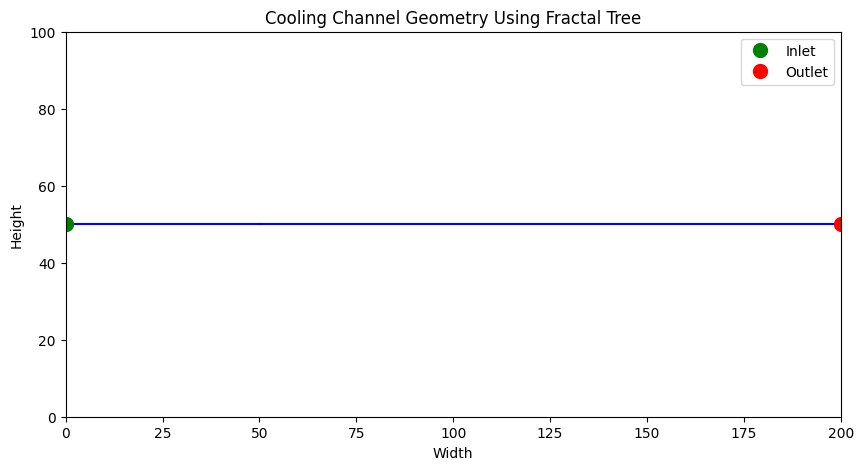

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Parameters
branch_angle = np.pi / 4  # Maximum branching angle
branch_probability = 0.7  # Probability to continue branching
min_branch_length = 10    # Minimum length of a branch

# List to store all lines (start and end points)
lines = []

def generate_branch(start_point, direction, length):
    if length < min_branch_length:
        return

    # Compute the end point of the branch
    end_point = start_point + length * np.array([np.cos(direction), np.sin(direction)])
    
    # Ensure the branch doesn't go out of bounds
    if not (0 <= end_point[0] <= width and 0 <= end_point[1] <= height):
        return
    
    # Add the line to the list
    lines.append((start_point, end_point))

    # Randomly decide whether to continue branching
    if np.random.rand() < branch_probability:
        # Generate left and right branches
        angle_variation = np.random.uniform(-branch_angle, branch_angle)
        new_direction = direction + angle_variation
        new_length = length * np.random.uniform(0.7, 0.9)
        generate_branch(end_point, new_direction, new_length)
        
        # Optionally create another branch
        if np.random.rand() < 0.5:
            angle_variation = np.random.uniform(-branch_angle, branch_angle)
            new_direction = direction + angle_variation
            new_length = length * np.random.uniform(0.7, 0.9)
            generate_branch(end_point, new_direction, new_length)
    else:
        # Direct the final branch towards the outlet
        direction_to_outlet = np.arctan2(outlet[1] - end_point[1], outlet[0] - end_point[0])
        final_length = np.linalg.norm(outlet - end_point)
        lines.append((end_point, outlet))

# Start generating from the inlet
initial_direction = np.arctan2(outlet[1] - inlet[1], outlet[0] - inlet[0])
initial_length = 50  # Starting length of branches
generate_branch(inlet, initial_direction, initial_length)

# Plotting
plt.figure(figsize=(10, 5))
for line in lines:
    start, end = line
    plt.plot([start[0], end[0]], [start[1], end[1]], 'b-')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Fractal Tree')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


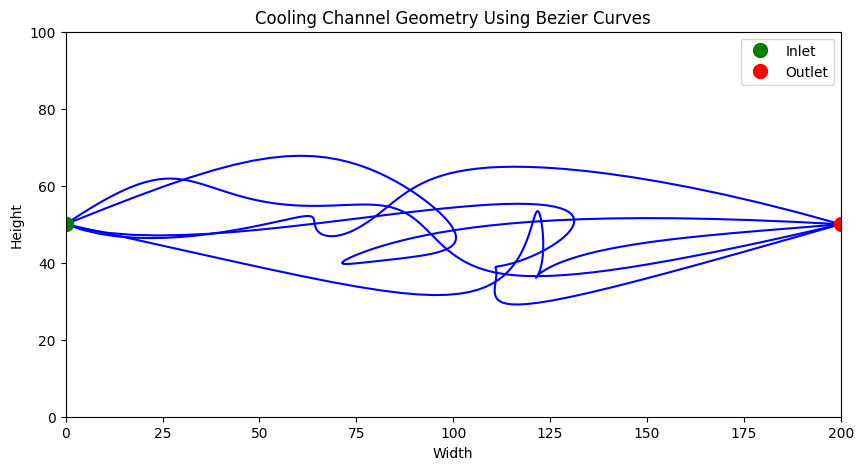

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Parameters
num_curves = 5  # Number of Bezier curves
control_points_per_curve = 8  # Number of control points per curve

def bezier_curve(points, num=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    for i in range(n + 1):
        binomial_coeff = comb(n, i)
        curve += binomial_coeff * (t[:, None] ** i) * ((1 - t)[:, None] ** (n - i)) * points[i]
    return curve

# Generate curves
plt.figure(figsize=(10, 5))
for _ in range(num_curves):
    # Random control points
    cps_x = np.random.uniform(0, width, control_points_per_curve)
    cps_y = np.random.uniform(0, height, control_points_per_curve)
    control_points = np.column_stack((cps_x, cps_y))
    
    # Insert inlet and outlet at the start and end
    control_points = np.vstack([inlet, control_points, outlet])
    
    # Generate and plot the Bezier curve
    curve = bezier_curve(control_points)
    plt.plot(curve[:, 0], curve[:, 1], 'b-')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Bezier Curves')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


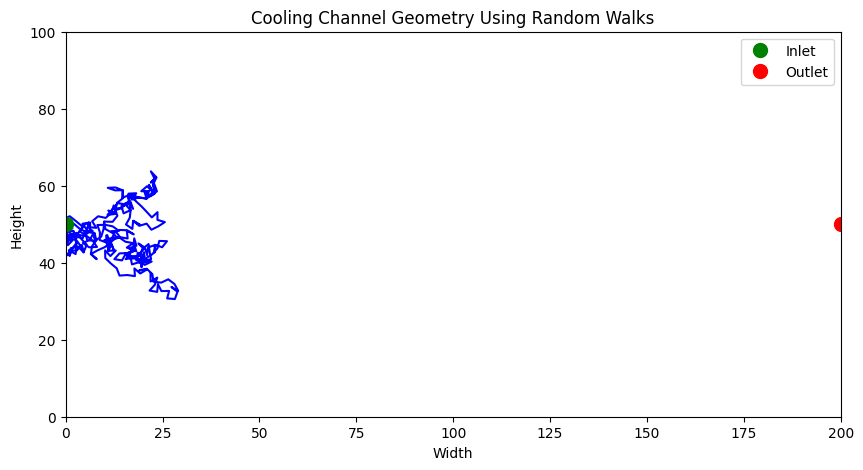

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Parameters
num_paths = 3        # Number of random paths
num_steps = 100      # Number of steps in each path
step_size = 2        # Size of each step
branch_probability = 0.3  # Probability to branch at each step

plt.figure(figsize=(10, 5))

for _ in range(num_paths):
    path = [inlet.copy()]
    current_point = inlet.copy()
    for i in range(num_steps):
        # Calculate bias towards the outlet
        distance_to_outlet = np.linalg.norm(outlet - current_point)
        bias_strength = 1 - (distance_to_outlet / np.linalg.norm(outlet - inlet))
        
        # Random direction with bias
        direction_to_outlet = (outlet - current_point) / distance_to_outlet
        random_direction = np.random.randn(2)
        random_direction = random_direction / np.linalg.norm(random_direction)
        direction = (1 - bias_strength) * random_direction + bias_strength * direction_to_outlet
        direction = direction / np.linalg.norm(direction)
        step = step_size * direction
        new_point = current_point + step
        
        # Keep within bounds
        new_point[0] = np.clip(new_point[0], 0, width)
        new_point[1] = np.clip(new_point[1], 0, height)
        path.append(new_point.copy())
        current_point = new_point.copy()
        
        # Check if near the outlet
        if np.linalg.norm(current_point - outlet) < step_size * 2:
            path.append(outlet.copy())
            break
        
        # Randomly branch
        if np.random.rand() < branch_probability:
            branch_path = path.copy()
            for j in range(i, num_steps):
                # Continue random walk for the branch
                branch_direction = np.random.randn(2)
                branch_direction = branch_direction / np.linalg.norm(branch_direction)
                branch_step = step_size * branch_direction
                branch_point = branch_path[-1] + branch_step
                branch_point[0] = np.clip(branch_point[0], 0, width)
                branch_point[1] = np.clip(branch_point[1], 0, height)
                branch_path.append(branch_point.copy())
                if np.linalg.norm(branch_point - outlet) < step_size * 2:
                    branch_path.append(outlet.copy())
                    break
            branch_path = np.array(branch_path)
            plt.plot(branch_path[:, 0], branch_path[:, 1], 'b-')
            break  # Stop current path when branching
    
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], 'b-')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Random Walks')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


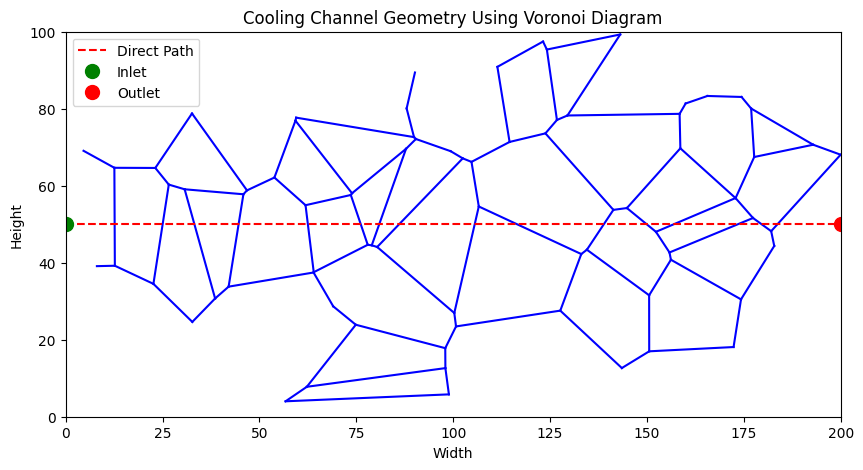

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Generate random seed points
num_points = 50
points = np.random.rand(num_points, 2)
points[:, 0] *= width
points[:, 1] *= height

# Include inlet and outlet in the points
points = np.vstack([points, inlet, outlet])

# Compute Voronoi diagram
vor = Voronoi(points)

# Plotting
plt.figure(figsize=(10, 5))
for simplex in vor.ridge_vertices:
    if simplex[0] >= 0 and simplex[1] >= 0:
        start = vor.vertices[simplex[0]]
        end = vor.vertices[simplex[1]]
        # Check if the line is within bounds
        if (0 <= start[0] <= width and 0 <= start[1] <= height and
            0 <= end[0] <= width and 0 <= end[1] <= height):
            plt.plot([start[0], end[0]], [start[1], end[1]], 'b-')

# Highlight paths from inlet to outlet
plt.plot([inlet[0], outlet[0]], [inlet[1], outlet[1]], 'r--', label='Direct Path')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Voronoi Diagram')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


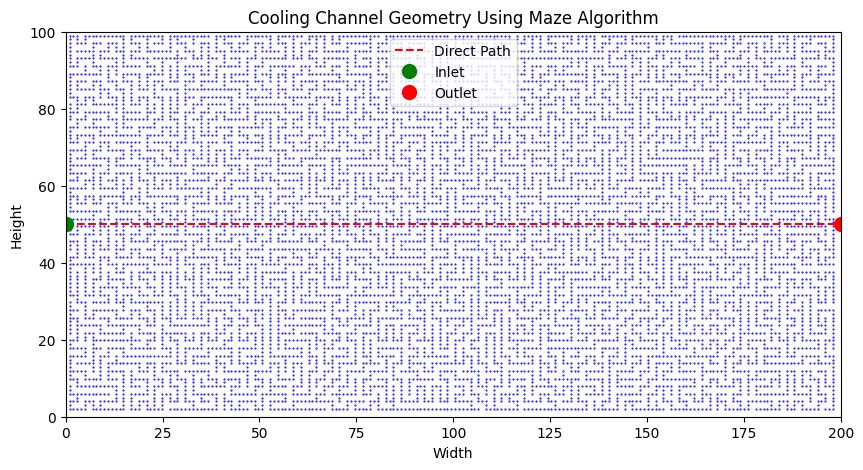

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Map dimensions (must be odd numbers for maze generation)
maze_width = 201
maze_height = 101

# Initialize maze grid
maze = np.zeros((maze_height, maze_width), dtype=np.uint8)

# Define maze generation using Recursive Backtracking
def carve_maze(x, y):
    directions = [(2, 0), (-2, 0), (0, 2), (0, -2)]
    np.random.shuffle(directions)
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 < nx < maze_width and 0 < ny < maze_height and maze[ny, nx] == 0:
            maze[ny - dy//2, nx - dx//2] = 1
            maze[ny, nx] = 1
            carve_maze(nx, ny)

# Start maze generation from inlet position
start_x, start_y = 1, maze_height // 2
maze[start_y, start_x] = 1
carve_maze(start_x, start_y)

# Convert maze grid to coordinates
y_coords, x_coords = np.where(maze == 1)
x_coords = x_coords * (width / maze_width)
y_coords = y_coords * (height / maze_height)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_coords, y_coords, 'b.', markersize=1)

# Draw path from inlet to outlet
plt.plot([0, width], [height / 2, height / 2], 'r--', label='Direct Path')

# Plot inlet and outlet
plt.plot(0, height / 2, 'go', markersize=10, label='Inlet')
plt.plot(width, height / 2, 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Maze Algorithm')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


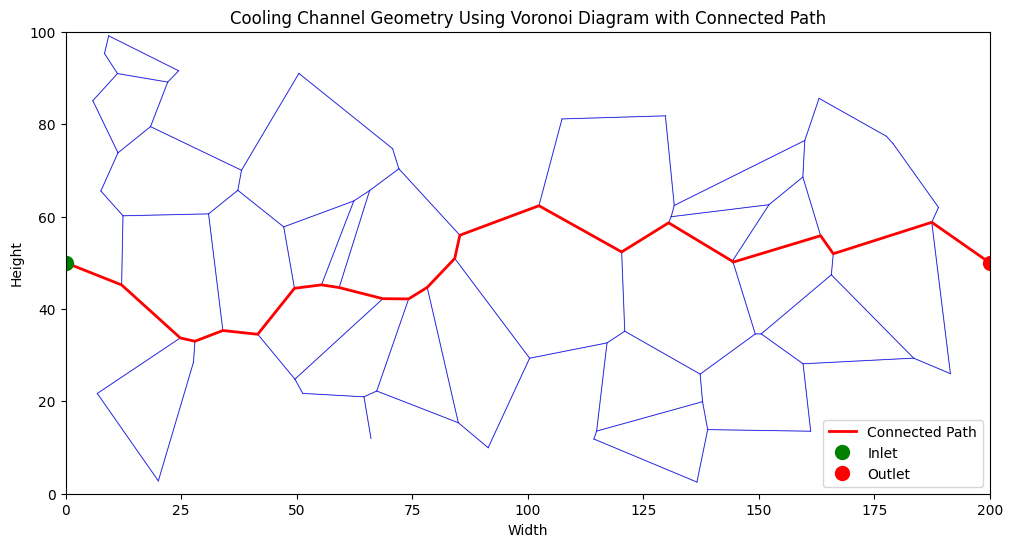

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import networkx as nx

# Map dimensions
width = 200
height = 100

# Inlet and outlet coordinates
inlet = np.array([0, 50])
outlet = np.array([200, 50])

# Generate random seed points
num_points = 50
np.random.seed(42)  # For reproducibility
points = np.random.rand(num_points, 2)
points[:, 0] *= width
points[:, 1] *= height

# Include inlet and outlet in the points
points = np.vstack([points, inlet, outlet])

# Compute Voronoi diagram
vor = Voronoi(points)

# Function to check if a point is within bounds
def is_within_bounds(point, width, height):
    return 0 <= point[0] <= width and 0 <= point[1] <= height

# Build a graph from Voronoi ridges
G = nx.Graph()

# Add Voronoi vertices as nodes
for idx, vertex in enumerate(vor.vertices):
    if is_within_bounds(vertex, width, height):
        G.add_node(idx, pos=vertex)

# Add edges between Voronoi vertices based on ridges
for ridge in vor.ridge_vertices:
    v1, v2 = ridge
    if v1 == -1 or v2 == -1:
        continue  # Ignore infinite ridges
    if is_within_bounds(vor.vertices[v1], width, height) and is_within_bounds(vor.vertices[v2], width, height):
        G.add_edge(v1, v2, weight=np.linalg.norm(vor.vertices[v1] - vor.vertices[v2]))

# Function to find the closest Voronoi vertex to a given point
def closest_vertex(point, vertices):
    distances = np.linalg.norm(vertices - point, axis=1)
    return np.argmin(distances)

# Extract all finite Voronoi vertices
finite_vertices = vor.vertices[np.all((vor.vertices >= 0) & (vor.vertices <= [width, height]), axis=1)]

# Find the closest Voronoi vertices to inlet and outlet
inlet_vertex = closest_vertex(inlet, vor.vertices)
outlet_vertex = closest_vertex(outlet, vor.vertices)

# Add inlet and outlet as separate nodes in the graph
G.add_node('inlet', pos=inlet)
G.add_node('outlet', pos=outlet)

# Connect inlet and outlet to their closest Voronoi vertices
G.add_edge('inlet', inlet_vertex, weight=np.linalg.norm(inlet - vor.vertices[inlet_vertex]))
G.add_edge('outlet', outlet_vertex, weight=np.linalg.norm(outlet - vor.vertices[outlet_vertex]))

# Find the shortest path using Dijkstra's algorithm
try:
    path = nx.shortest_path(G, source='inlet', target='outlet', weight='weight')
    # Convert node indices to coordinates
    path_coords = [G.nodes[node]['pos'] if node not in ['inlet', 'outlet'] else (inlet if node == 'inlet' else outlet) for node in path]
except nx.NetworkXNoPath:
    print("No path found between inlet and outlet.")
    path_coords = []

# Plotting
plt.figure(figsize=(12, 6))

# Plot Voronoi ridges
for ridge in vor.ridge_vertices:
    if ridge[0] == -1 or ridge[1] == -1:
        continue  # Skip infinite ridges
    v1, v2 = vor.vertices[ridge[0]], vor.vertices[ridge[1]]
    if is_within_bounds(v1, width, height) and is_within_bounds(v2, width, height):
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'lightgray', linewidth=1)

# Highlight the Voronoi edges
for ridge in vor.ridge_vertices:
    if ridge[0] == -1 or ridge[1] == -1:
        continue
    v1, v2 = vor.vertices[ridge[0]], vor.vertices[ridge[1]]
    if is_within_bounds(v1, width, height) and is_within_bounds(v2, width, height):
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'b-', linewidth=0.5)

# Plot the shortest path
if path_coords:
    path_coords = np.array(path_coords)
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'r-', linewidth=2, label='Connected Path')

# Plot inlet and outlet
plt.plot(inlet[0], inlet[1], 'go', markersize=10, label='Inlet')
plt.plot(outlet[0], outlet[1], 'ro', markersize=10, label='Outlet')

plt.title('Cooling Channel Geometry Using Voronoi Diagram with Connected Path')
plt.xlim(0, width)
plt.ylim(0, height)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Height')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


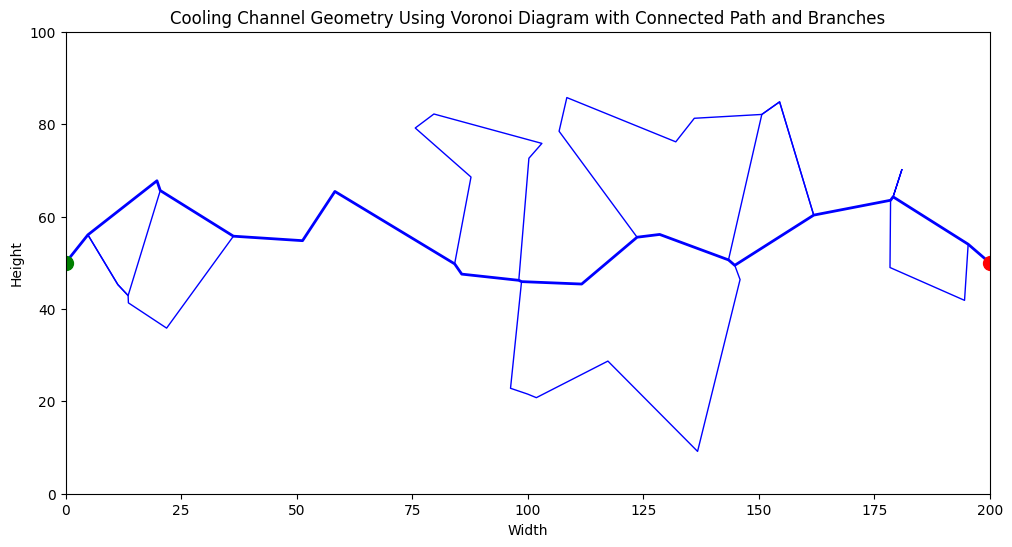

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import networkx as nx

width = 200
height = 100
inlet = np.array([0, 50])
outlet = np.array([200, 50])
num_points = 50
np.random.seed(40)
points = np.random.rand(num_points, 2)
points[:, 0] *= width
points[:, 1] *= height
points = np.vstack([points, inlet, outlet])
vor = Voronoi(points)

def is_within_bounds(point, width, height):
    return 0 <= point[0] <= width and 0 <= point[1] <= height

G = nx.Graph()
for idx, vertex in enumerate(vor.vertices):
    if is_within_bounds(vertex, width, height):
        G.add_node(idx, pos=vertex)

for ridge in vor.ridge_vertices:
    v1, v2 = ridge
    if v1 == -1 or v2 == -1:
        continue
    if is_within_bounds(vor.vertices[v1], width, height) and is_within_bounds(vor.vertices[v2], width, height):
        distance = np.linalg.norm(vor.vertices[v1] - vor.vertices[v2])
        G.add_edge(v1, v2, weight=distance)

def closest_vertex(point, vertices):
    distances = np.linalg.norm(vertices - point, axis=1)
    return np.argmin(distances)

inlet_vertex = closest_vertex(inlet, vor.vertices)
outlet_vertex = closest_vertex(outlet, vor.vertices)
G.add_node('inlet', pos=inlet)
G.add_node('outlet', pos=outlet)
G.add_edge('inlet', inlet_vertex, weight=np.linalg.norm(inlet - vor.vertices[inlet_vertex]))
G.add_edge('outlet', outlet_vertex, weight=np.linalg.norm(outlet - vor.vertices[outlet_vertex]))

try:
    main_path = nx.shortest_path(G, source='inlet', target='outlet', weight='weight')
    path_coords = [G.nodes[node]['pos'] if node not in ['inlet', 'outlet'] else (inlet if node == 'inlet' else outlet) for node in main_path]
except nx.NetworkXNoPath:
    path_coords = []

def add_branches(G, main_path_nodes, max_branches=15, branch_length=7):
    branches_added = 0
    for node in main_path_nodes:
        if branches_added >= max_branches:
            break
        neighbors = list(G.neighbors(node))
        possible_branches = [n for n in neighbors if n not in main_path_nodes and n != 'inlet' and n != 'outlet']
        np.random.shuffle(possible_branches)
        for branch_start in possible_branches:
            if branches_added >= max_branches:
                break
            branch = [node, branch_start]
            current = branch_start
            visited = set(branch)
            while len(branch) < branch_length:
                nbrs = list(G.neighbors(current))
                nbrs = [n for n in nbrs if n not in visited and n not in main_path_nodes]
                if not nbrs:
                    break
                next_node = np.random.choice(nbrs)
                branch.append(next_node)
                visited.add(next_node)
                current = next_node
            possible_connections = list(G.neighbors(current))
            connections = [n for n in possible_connections if n in main_path_nodes]
            if connections:
                connection = np.random.choice(connections)
                branch.append(connection)
                branches_added += 1
                yield branch

main_path_nodes = set(main_path)
branches = list(add_branches(G, main_path_nodes, max_branches=15, branch_length=7))

plt.figure(figsize=(12, 6))
if path_coords:
    path_coords = np.array(path_coords)
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
for branch in branches:
    branch_coords = [G.nodes[node]['pos'] if node not in ['inlet', 'outlet'] else (inlet if node == 'inlet' else outlet) for node in branch]
    branch_coords = np.array(branch_coords)
    plt.plot(branch_coords[:, 0], branch_coords[:, 1], 'b-', linewidth=1)
plt.plot(inlet[0], inlet[1], 'go', markersize=10)
plt.plot(outlet[0], outlet[1], 'ro', markersize=10)
plt.title('Cooling Channel Geometry Using Voronoi Diagram with Connected Path and Branches')
plt.xlim(0, width)
plt.ylim(0, height)
plt.xlabel('Width')
plt.ylabel('Height')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


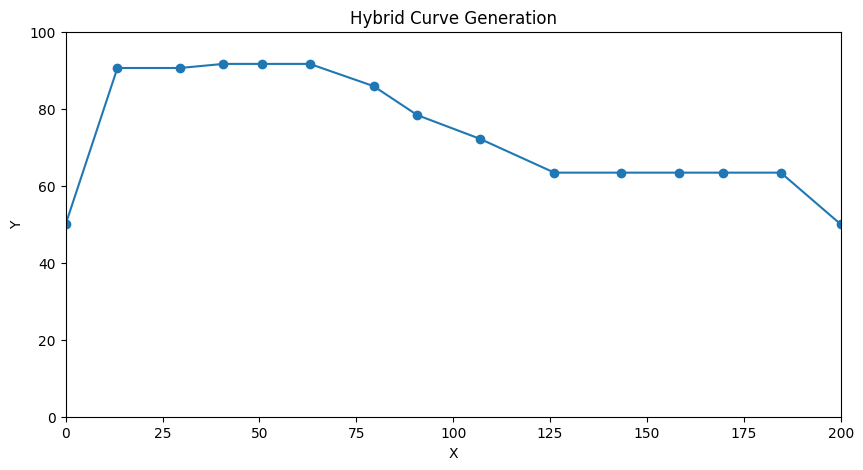

In [1]:
import matplotlib.pyplot as plt
import random

def hybrid_curve_generation():
    inlet = (200, 50)
    outlet = (0, 50)
    current_point = inlet
    points = [current_point]
    num_segments = random.randint(5, 15)
    for _ in range(num_segments):
        direction = random.choice(['straight', 'curve'])
        step_x = random.uniform(-20, -10)
        if current_point[0] + step_x < outlet[0]:
            step_x = outlet[0] - current_point[0]
        if direction == 'straight':
            new_point = (current_point[0] + step_x, current_point[1])
        else:
            delta_y = random.uniform(-20, 20)
            new_y = max(0, min(100, current_point[1] + delta_y))
            new_point = (current_point[0] + step_x, new_y)
        points.append(new_point)
        current_point = new_point
        if current_point[0] <= outlet[0]:
            break
    if current_point != outlet:
        points.append(outlet)
    x, y = zip(*points)
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker='o')
    plt.xlim(0, 200)
    plt.ylim(0, 100)
    plt.title("Hybrid Curve Generation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

hybrid_curve_generation()



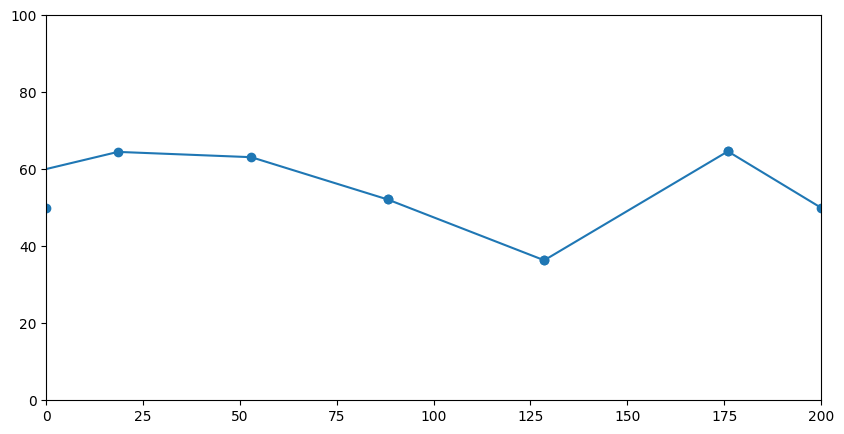

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

def generate_hybrid_channel():
    points = [(200, 50)]
    current_pos = np.array([200, 50])
    while current_pos[0] > 0:
        segment_type = random.choice(['straight', 'curve'])
        if segment_type == 'straight':
            dx = random.uniform(-50, -10)
            dy = random.uniform(-20, 20)
            new_pos = current_pos + np.array([dx, dy])
        else:
            control_offset = random.uniform(-30, 30)
            mid_x = current_pos[0] + random.uniform(-50, -10)
            mid_y = current_pos[1] + control_offset
            new_pos = np.array([mid_x, mid_y])
            points.append(tuple(new_pos))
        points.append(tuple(new_pos))
        current_pos = new_pos
    points.append((0, 50))
    return points

channel = generate_hybrid_channel()
x, y = zip(*channel)
plt.figure(figsize=(10,5))
plt.plot(x, y, marker='o')
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


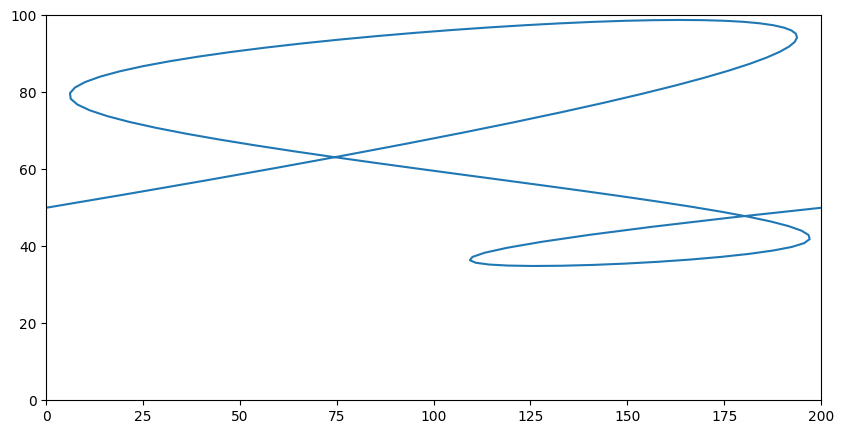

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splprep, splev
import random

def generate_spline_channel():
    num_points = random.randint(4,8)
    x = [200]
    y = [50]
    for _ in range(num_points-2):
        xi = random.uniform(0,200)
        yi = random.uniform(0,100)
        x.append(xi)
        y.append(yi)
    x.append(0)
    y.append(50)
    tck, _ = splprep([x, y], s=0)
    u = np.linspace(0,1,100)
    spline = splev(u, tck)
    return spline

spline = generate_spline_channel()
plt.figure(figsize=(10,5))
plt.plot(spline[0], spline[1])
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


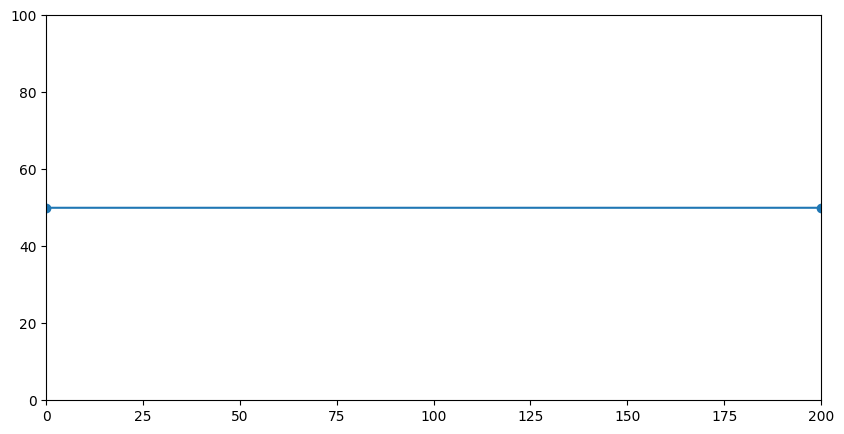

In [4]:
import matplotlib.pyplot as plt
import random

def l_system(axiom, rules, iterations):
    for _ in range(iterations):
        new_axiom = ""
        for char in axiom:
            new_axiom += rules.get(char, char)
        axiom = new_axiom
    return axiom

def generate_l_system_channel():
    axiom = "F"
    rules = {"F": "F+F-F-F+F"}
    iterations = random.randint(3,5)
    instructions = l_system(axiom, rules, iterations)
    angle = 90
    stack = []
    pos = [200, 50]
    angle_dir = 0
    points = [tuple(pos)]
    for cmd in instructions:
        if cmd == 'F':
            dx = np.cos(np.radians(angle_dir)) * 10
            dy = np.sin(np.radians(angle_dir)) * 10
            pos = [pos[0] + dx, pos[1] + dy]
            points.append(tuple(pos))
        elif cmd == '+':
            angle_dir += angle
        elif cmd == '-':
            angle_dir -= angle
        elif cmd == '[':
            stack.append((pos.copy(), angle_dir))
        elif cmd == ']':
            pos, angle_dir = stack.pop()
            points.append(tuple(pos))
    points.append((0,50))
    return points

channel = generate_l_system_channel()
x, y = zip(*channel)
plt.figure(figsize=(10,5))
plt.plot(x, y, marker='o')
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


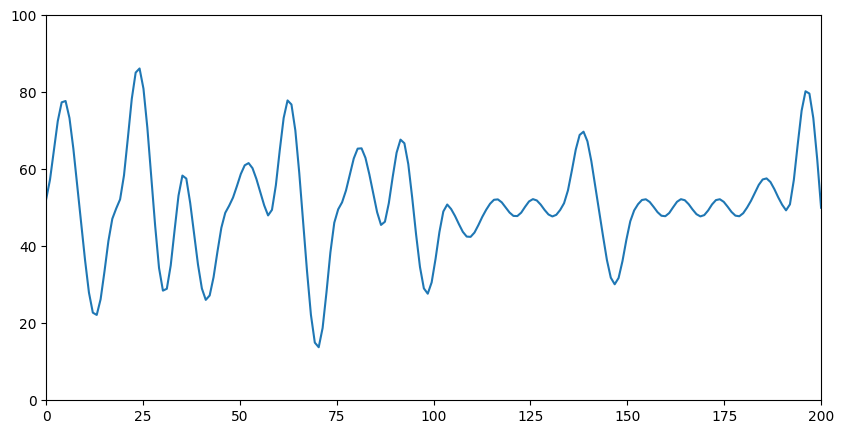

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
from noise import pnoise1

def generate_perlin_channel():
    length = 200
    scale = random.uniform(0.05, 0.2)
    amplitude = random.uniform(20,40)
    x = np.linspace(200,0, length)
    y = 50 + np.array([pnoise1(i*scale) for i in range(length)]) * amplitude
    return x, y

x, y = generate_perlin_channel()
plt.figure(figsize=(10,5))
plt.plot(x, y)
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


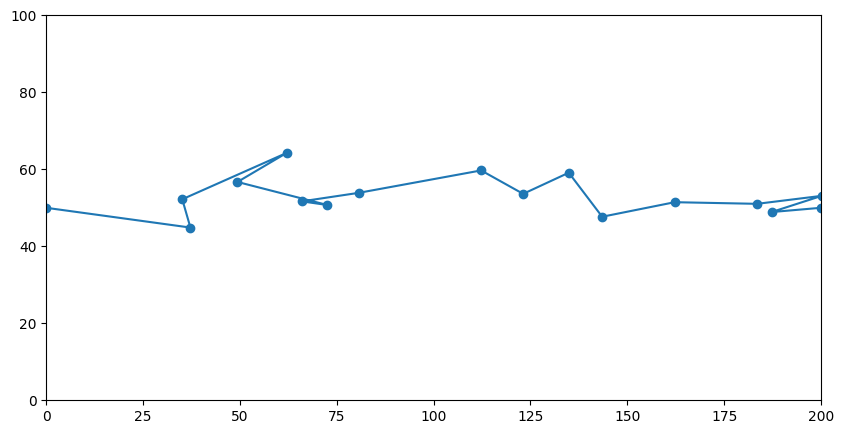

In [6]:
import matplotlib.pyplot as plt
import random

def recursive_subdivide(x0, y0, x1, y1, depth, points):
    if depth ==0:
        points.append((x1, y1))
        return
    xm = (x0 + x1)/2 + random.uniform(-20,20)
    ym = (y0 + y1)/2 + random.uniform(-10,10)
    recursive_subdivide(x0, y0, xm, ym, depth-1, points)
    recursive_subdivide(xm, ym, x1, y1, depth-1, points)

def generate_fractal_channel():
    points = [(200,50)]
    recursive_subdivide(200,50,0,50, random.randint(3,5), points)
    return points

channel = generate_fractal_channel()
x, y = zip(*channel)
plt.figure(figsize=(10,5))
plt.plot(x, y, marker='o')
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


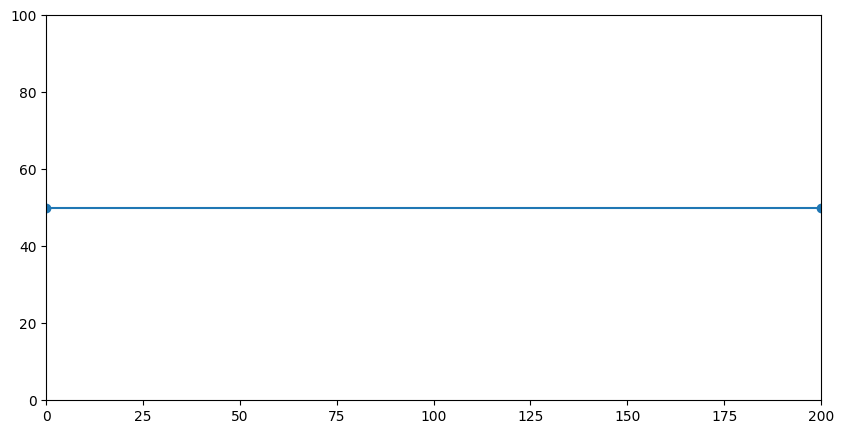

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

def generate_graph_channel():
    G = nx.Graph()
    G.add_node('inlet', pos=(200, 50))
    G.add_node('outlet', pos=(0, 50))
    num_extra_nodes = random.randint(5, 15)
    for i in range(num_extra_nodes):
        x = random.uniform(0, 200)
        y = random.uniform(0, 100)
        G.add_node(f'node{i}', pos=(x, y))
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if random.random() < 0.1:
                G.add_edge(nodes[i], nodes[j])
    if not nx.has_path(G, 'inlet', 'outlet'):
        G.add_edge('inlet', 'outlet')
    pos = nx.get_node_attributes(G, 'pos')
    paths = list(nx.all_simple_paths(G, 'inlet', 'outlet', cutoff=10))
    if paths:
        path = random.choice(paths)
    else:
        path = ['inlet', 'outlet']
    channel = [pos[node] for node in path]
    return channel

channel = generate_graph_channel()
x, y = zip(*channel)
plt.figure(figsize=(10,5))
plt.plot(x, y, marker='o')
plt.xlim(0,200)
plt.ylim(0,100)
plt.show()


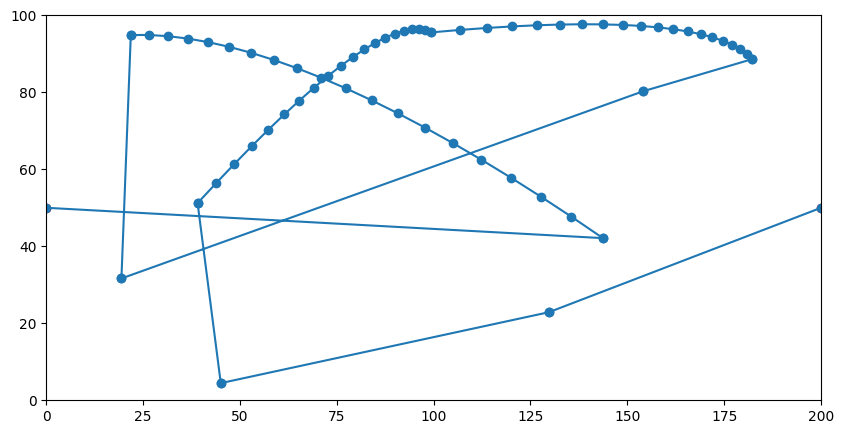

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from scipy.interpolate import splprep, splev

def generate_random_graph(inlet, outlet, width, height, num_nodes):
    G = nx.Graph()
    G.add_node('inlet', pos=inlet)
    G.add_node('outlet', pos=outlet)
    for i in range(num_nodes):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        G.add_node(f'node{i}', pos=(x, y))
    potential_edges = [(u, v) for u in G.nodes() for v in G.nodes() if u != v]
    random.shuffle(potential_edges)
    for u, v in potential_edges:
        if (G.degree(u) < 4 and G.degree(v) < 4) and not nx.has_path(G, u, v):
            G.add_edge(u, v)
    while not nx.has_path(G, 'inlet', 'outlet'):
        u = random.choice([n for n in G.nodes() if n != 'outlet'])
        G.add_edge('inlet', u)
    for node in G.nodes():
        if node not in ['inlet', 'outlet'] and G.degree(node) < 2:
            neighbors = [n for n in G.nodes() if n != node]
            v = random.choice(neighbors)
            G.add_edge(node, v)
    return G

def get_channel_paths(G):
    paths = list(nx.simple_paths.all_simple_paths(G, 'inlet', 'outlet', cutoff=10))
    if paths:
        return random.choice(paths)
    return ['inlet', 'outlet']

def add_curves_to_paths(channel, pos):
    curved_channel = []
    for i in range(len(channel)-1):
        x0, y0 = pos[channel[i]]
        x1, y1 = pos[channel[i+1]]
        if random.choice([True, False]):
            num_points = 20
            t = np.linspace(0, 1, num_points)
            ctrl_x = (x0 + x1) / 2 + random.uniform(-30, 30)
            ctrl_y = (y0 + y1) / 2 + random.uniform(-30, 30)
            bezier_x = (1-t)**2 * x0 + 2*(1-t)*t * ctrl_x + t**2 * x1
            bezier_y = (1-t)**2 * y0 + 2*(1-t)*t * ctrl_y + t**2 * y1
            curved_channel.extend(zip(bezier_x, bezier_y))
        else:
            curved_channel.append((x0, y0))
            curved_channel.append((x1, y1))
    return curved_channel

inlet = (200, 50)
outlet = (0, 50)
width = 200
height = 100
num_nodes = random.randint(10, 50)
G = generate_random_graph(inlet, outlet, width, height, num_nodes)
path = get_channel_paths(G)
pos = nx.get_node_attributes(G, 'pos')
channel = add_curves_to_paths(path, pos)
x, y = zip(*channel)
plt.figure(figsize=(10,5))
plt.plot(x, y, marker='o')
plt.xlim(0,200)
plt.ylim(0,100)
plt.scatter(*zip(*[inlet, outlet]), color='red')
plt.show()


In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from scipy.interpolate import make_interp_spline

def generate_random_graph(inlet, outlet, width, height, num_nodes):
    G = nx.Graph()
    G.add_node('inlet', pos=inlet)
    G.add_node('outlet', pos=outlet)
    for i in range(num_nodes):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        G.add_node(f'node{i}', pos=(x, y))
    nodes = list(G.nodes())
    attempts = 0
    while not nx.is_connected(G):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
        attempts +=1
        if attempts > num_nodes * 10:
            break
    for node in nodes:
        if node not in ['inlet', 'outlet']:
            while G.degree(node) < 2:
                v = random.choice(nodes)
                if v != node and not G.has_edge(node, v):
                    G.add_edge(node, v)
    return G

def get_channel_paths(G):
    paths = list(nx.all_simple_paths(G, 'inlet', 'outlet'))
    if paths:
        return random.choice(paths)
    return ['inlet', 'outlet']

def create_channel_geometry(path, pos):
    channel = []
    for i in range(len(path)-1):
        p1 = pos[path[i]]
        p2 = pos[path[i+1]]
        if random.choice([True, False]):
            channel.append((p1, p2, 'straight'))
        else:
            mid_x = (p1[0] + p2[0])/2 + random.uniform(-30,30)
            mid_y = (p1[1] + p2[1])/2 + random.uniform(-30,30)
            channel.append(((p1, (mid_x, mid_y), p2), 'curved'))
    return channel

def plot_channel(channel):
    for segment, seg_type in channel:
        if seg_type == 'straight':
            x, y = zip(*segment)
            plt.plot(x, y, color='blue')
        else:
            points, _ = zip(*segment)
            x = [p[0] for p in segment]
            y = [p[1] for p in segment]
            spl = make_interp_spline(np.linspace(0,1,len(x)), np.array([x, y]), k=2)
            t = np.linspace(0,1,100)
            smooth = spl(t)
            plt.plot(smooth[0], smooth[1], color='blue')
    plt.scatter(*zip(*[inlet, outlet]), color='red')
    plt.xlim(0,200)
    plt.ylim(0,100)
    plt.show()

inlet = (200, 50)
outlet = (0, 50)
width = 200
height = 100
num_nodes = random.randint(10, 20)
G = generate_random_graph(inlet, outlet, width, height, num_nodes)
path = get_channel_paths(G)
pos = nx.get_node_attributes(G, 'pos')
channel = create_channel_geometry(path, pos)
plot_channel(channel)


ValueError: Shapes of x (3,) and y (2, 3) are incompatible

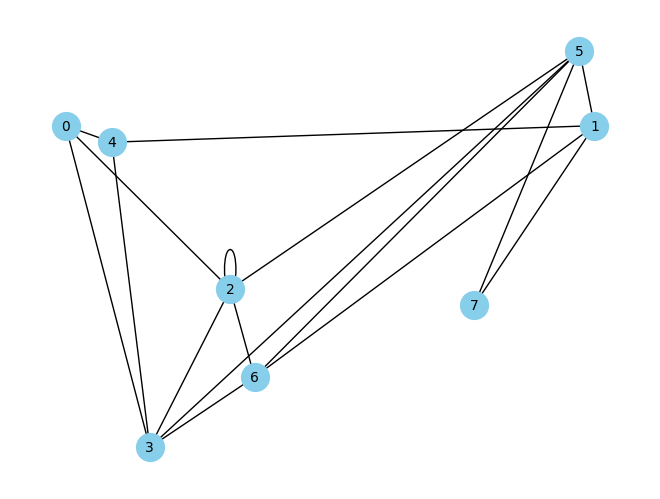

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

width, height = 200, 100

points = np.random.rand(6, 2) * [width, height]
fixed_points = np.array([[0, 50], [200, 50]])
points = np.vstack([fixed_points, points])

G = nx.Graph()
for i, point in enumerate(points):
    G.add_node(i, pos=point)

edges = []
for i in range(len(points)):
    distances = [np.linalg.norm(points[i] - points[j]) for j in range(len(points)) if i != j]
    nearest = np.argsort(distances)[:2]
    for n in nearest:
        edges.append((i, n))
        if len(edges) >= len(points)*2:
            break
    if len(edges) >= len(points)*2:
        break
G.add_edges_from(edges)

pos = {i: points[i] for i in range(len(points))}
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=400, font_size=10, font_color='black')
plt.show()


Total points (including fixed points): 15


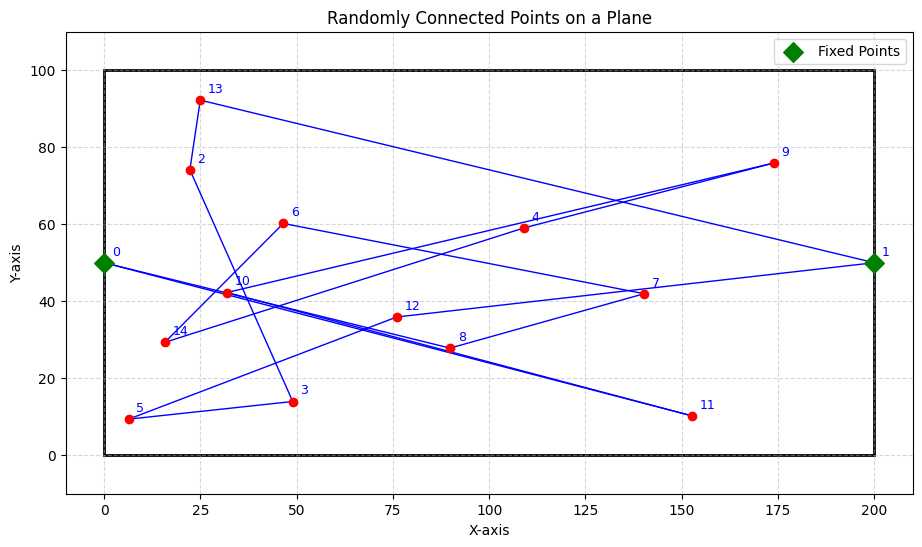

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

def generate_non_overlapping_points(width, height, num_points, min_distance, fixed_points=[]):
    """
    Generates a list of points within the given width and height, ensuring that
    each point is at least min_distance away from others.
    
    :param width: Width of the plane
    :param height: Height of the plane
    :param num_points: Total number of points to generate (including fixed_points)
    :param min_distance: Minimum distance between any two points
    :param fixed_points: List of points that must be included
    :return: List of (x, y) tuples
    """
    points = fixed_points.copy()
    attempts = 0
    max_attempts = num_points * 100  # Prevent infinite loop

    while len(points) < num_points and attempts < max_attempts:
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        candidate = (x, y)
        too_close = False
        for p in points:
            distance = math.hypot(p[0] - candidate[0], p[1] - candidate[1])
            if distance < min_distance:
                too_close = True
                break
        if not too_close:
            points.append(candidate)
        attempts += 1

    if len(points) < num_points:
        raise ValueError(f"Could only place {len(points)} points out of {num_points} requested. "
                         f"Try reducing the number of points or the minimum distance.")

    return points

# Set a random seed for reproducibility (optional)
random.seed(42)

# Define plane size
plane_width = 200
plane_height = 100

# Define fixed points
fixed_points = [(0, 50), (200, 50)]

# Randomly select the total number of points between 5 and 15
total_points = random.randint(5, 15)
print(f"Total points (including fixed points): {total_points}")


min_distance = 15

# Generate non-overlapping random points
try:
    all_points = generate_non_overlapping_points(
        width=plane_width,
        height=plane_height,
        num_points=total_points,
        min_distance=min_distance,
        fixed_points=fixed_points
    )
except ValueError as e:
    print(e)
    exit(1)

# Number of total points
total_points = len(all_points)

# Create a 2-regular graph (each node has degree 2)
# This ensures that each point is connected to exactly two other points
# A 2-regular graph is a collection of cycles
try:
    G = nx.random_regular_graph(d=2, n=total_points, seed=42)
except nx.exception.NetworkXError as e:
    print(f"Error creating 2-regular graph: {e}")
    exit(1)

# Assign positions to graph nodes
pos = {i: all_points[i] for i in range(total_points)}

# Start plotting
plt.figure(figsize=(12, 6))

# Draw the plane as a rectangle
rectangle = plt.Rectangle((0, 0), plane_width, plane_height,
                          linewidth=2, edgecolor='black', facecolor='none')
plt.gca().add_patch(rectangle)

# Draw connections (edges)
for edge in G.edges():
    point1 = pos[edge[0]]
    point2 = pos[edge[1]]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]],
             'b-', linewidth=1)

# Draw nodes (points)
x_coords, y_coords = zip(*all_points)
plt.scatter(x_coords, y_coords, c='red', zorder=5)

# Highlight fixed points with a different color and marker
fixed_indices = list(range(len(fixed_points)))
plt.scatter([all_points[i][0] for i in fixed_indices],
            [all_points[i][1] for i in fixed_indices],
            c='green', marker='D', s=100, label='Fixed Points', zorder=6)

# Annotate nodes with their indices
for idx, (x, y) in enumerate(all_points):
    plt.text(x + 2, y + 2, str(idx), fontsize=9, color='blue')

# Set plot limits slightly larger than the plane for better visualization
plt.xlim(-10, plane_width + 10)
plt.ylim(-10, plane_height + 10)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Randomly Connected Points on a Plane')

# Add legend
plt.legend()

# Add grid for reference
plt.grid(True, linestyle='--', alpha=0.5)

# Maintain aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Display the plot
plt.show()


Total points (including fixed points): 12


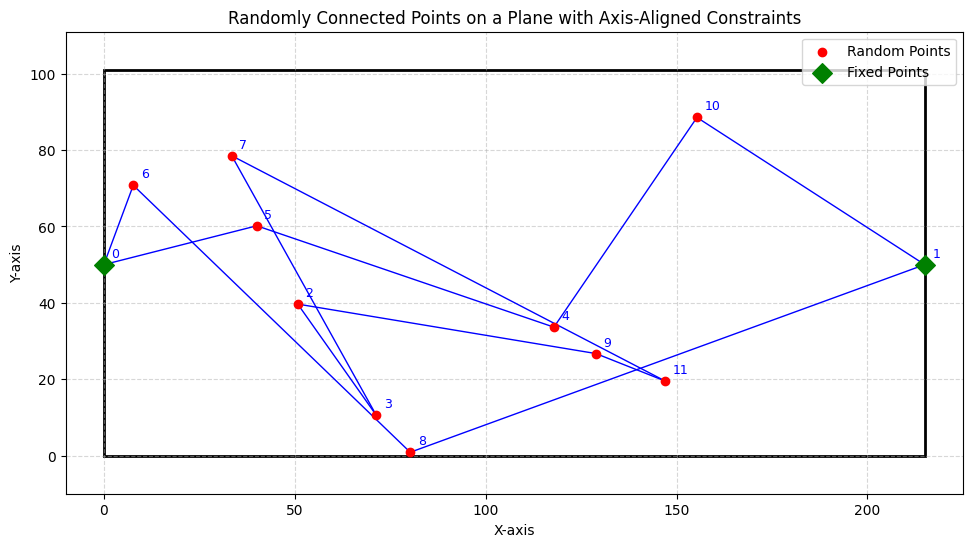

In [44]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

def generate_non_overlapping_points_axis_aligned(width, height, num_points, min_x_diff, min_y_diff, fixed_points=[]):
    points = fixed_points.copy()
    attempts = 0
    max_attempts = num_points * 100
    while len(points) < num_points and attempts < max_attempts:
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        candidate = (x, y)
        too_close = False
        for p in points:
            if abs(p[0] - candidate[0]) < min_x_diff or abs(p[1] - candidate[1]) < min_y_diff:
                too_close = True
                break
        if not too_close:
            points.append(candidate)
        attempts += 1
    if len(points) < num_points:
        raise ValueError("Could not place all points.")
    return points

plane_width = 215
plane_height = 101
fixed_points = [(0, 50), (215, 50)]
min_x_diff = 6
min_y_diff = 6

while True:
    total_points = random.randint(10, 17)
    print(f"Total points (including fixed points): {total_points}")
    try:
        all_points = generate_non_overlapping_points_axis_aligned(
            plane_width,
            plane_height,
            total_points,
            min_x_diff,
            min_y_diff,
            fixed_points
        )
        break
    except ValueError:
        pass

G = nx.random_regular_graph(d=2, n=total_points, seed=42)
pos = {i: all_points[i] for i in range(total_points)}
plt.figure(figsize=(12, 6))
rectangle = plt.Rectangle((0, 0), plane_width, plane_height, linewidth=2, edgecolor='black', facecolor='none')
plt.gca().add_patch(rectangle)
for edge in G.edges():
    point1 = pos[edge[0]]
    point2 = pos[edge[1]]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-', linewidth=1)
x_coords, y_coords = zip(*all_points)
plt.scatter(x_coords, y_coords, c='red', zorder=5, label='Random Points')
fixed_indices = list(range(len(fixed_points)))
if fixed_indices:
    plt.scatter(
        [all_points[i][0] for i in fixed_indices],
        [all_points[i][1] for i in fixed_indices],
        c='green',
        marker='D',
        s=100,
        label='Fixed Points',
        zorder=6
    )
for idx, (x, y) in enumerate(all_points):
    plt.text(x + 2, y + 2, str(idx), fontsize=9, color='blue')
plt.xlim(-10, plane_width + 10)
plt.ylim(-10, plane_height + 10)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Randomly Connected Points on a Plane with Axis-Aligned Constraints')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
